## Generate gene_set_details.csv

In [2]:
import pandas as pd
import json
import random

In [ ]:
rephrase = pd.read_csv('/data/wchen19/geneset_summarization/dataset/reactome_rephrased_rationale_hs.csv', header=None) # generated by ChatGPT
geneset = pd.read_csv('gpt_training_bio-main/llama2_ft/trl/train_test_data/hs_gene_set_details.csv') # extracted from MsigDB, all genesets for human/mouse
genelis = pd.read_csv('/data/wchen19/geneset_summarization/dataset/hs_gene_set_gene_symbol.csv')

geneset2rephrase = dict(zip(rephrase[0], rephrase[1]))
geneset_dic = dict(zip(geneset['gene_set_id'], geneset['description_brief']))

genelis_dic = {}
ids, genes = [], []

# Filter out genesets that have more than 500 genes
for key, group in genelis.groupby(by = 'gene_set_id')['symbol']:
    ids.append(key)
    genes.append(', '.join(group.values.tolist()))
    if len(group) <= 500:
        genelis_dic[key] = group.values.tolist()

index = rephrase[0].values
df = geneset[geneset['gene_set_id'].isin(index)]
listgene = [genelis_dic[i] for i in index]
df['genelist'] = listgene
df['rephrased'] = [geneset2rephrase[i] for i in index]
df.reset_index(inplace=True)
df.iloc[:, 1:].to_csv('reactome_human_gene_set_details.csv')

## Generate json files for training and testing

In [18]:
# Geneset of interest
geneset = pd.read_csv('/data/wchen19/geneset_summarization/tmp_data_jinbo/reactome_human.csv')
# NCBI Gene information
gene_info = pd.read_table('/data/wchen19/geneset_summarization/dataset/Homo_sapiens.gene_info')
# Make 3 dictionaries, one for geneset description: id to description; one for geneset genes: id to genes; one for gene information: gene symbol to gene description
geneset_dic = dict(zip(geneset['gene_set_id'], geneset['gpt description']))

# Check this line
genelis_dic = dict(zip(geneset['gene_set_id'], geneset['genelist'].apply(lambda x: eval(x))))
#genelis_dic = dict(zip(geneset['gene_set_id'], geneset['genelist'].apply(lambda x: x.split(' '))))
gene_info_dic = dict(zip(gene_info['Symbol'], gene_info['description']))
# Add gene information to each gene
for id, lis in genelis_dic.items():
   i = 0
   for gene in lis:
      if gene in gene_info_dic.keys():
         genelis_dic[id][i] = gene + ': ' + gene_info_dic[gene]
      i += 1

# Check genelis_dic
genelis_dic

{29734: ['JAK2: Janus kinase 2',
  'TYK2: tyrosine kinase 2',
  'CBL: Cbl proto-oncogene',
  'STAT1: signal transducer and activator of transcription 1',
  'IL6ST: interleukin 6 cytokine family signal transducer',
  'IL6: interleukin 6',
  'IL6R: interleukin 6 receptor',
  'JAK1: Janus kinase 1',
  'STAT3: signal transducer and activator of transcription 3',
  'PTPN11: protein tyrosine phosphatase non-receptor type 11',
  'SOCS3: suppressor of cytokine signaling 3'],
 29735: ['BAD: BCL2 associated agonist of cell death',
  'CFLAR: CASP8 and FADD like apoptosis regulator',
  'PSMB1: proteasome 20S subunit beta 1',
  'PSMC4: proteasome 26S subunit, ATPase 4',
  'BID: BH3 interacting domain death agonist',
  'VIM: vimentin',
  'FAS: Fas cell surface death receptor',
  'BAK1: BCL2 antagonist/killer 1',
  'DAPK2: death associated protein kinase 2',
  'CDH1: cadherin 1',
  'PSMA4: proteasome 20S subunit alpha 4',
  'DSG2: desmoglein 2',
  'CASP8: caspase 8',
  'PRKCQ: protein kinase C theta'

In [5]:
def get_train_json(geneset_dic, genelis_dic, train_index, file_path):
    sentencelis = []
    for index in train_index:

        sentence = [
        {"role": "system", "content": "You are a senior biologist."},
        {
            'role': 'user', 'content': 'Propose a brief description for the most prominent biological function performed by the given set of genes. Be concise, do not use unnecessary words. Be specific, avoid overly general statements such as \"the genes are involved in various cellular processes\". Be factual, do not editorialize. The genes and corresponding descriptions are: ' + '; '.join(genelis_dic[index])
        },
        {'role': 'assistant', 'content': geneset_dic[index]}
        ]
        sentencelis.append(sentence)

    formatted_data = [ {"sentence": item} for item in sentencelis]
    df_train = pd.DataFrame(formatted_data, columns=['sentence'])
    df_train.to_json(file_path, orient='records', lines=True)

def get_test_json(geneset_dic, genelis_dic, test_index, file_path):
    inputlis,outputlis = [],[]
    for index in test_index:
        input  = [
        {"role": "system", "content": "You are a senior biologist."},
        {
            'role': 'user', 'content': 'Propose a brief description for the most prominent biological function performed by the given set of genes. Be concise, do not use unnecessary words. Be specific, avoid overly general statements such as \"the genes are involved in various cellular processes\". Be factual, do not editorialize. The genes and corresponding descriptions are: ' + '; '.join(genelis_dic[index])
        }
        ]
        output = geneset_dic[index]
        inputlis.append(input)
        outputlis.append(output)
    df_test = pd.DataFrame(
        {'input': inputlis,
        'output': outputlis},
        columns = ['input', 'output'])
    df_test.to_json(file_path, orient='records',lines=True)

In [19]:
get_test_json(geneset_dic, genelis_dic, geneset['gene_set_id'].values, '/data/wchen19/geneset_summarization/tmp_data_jinbo/reactome_human.json')

In [ ]:
# split index into train and test.
import random
indexlis = geneset['gene_set_id'].values
random.seed(42)
random.shuffle(indexlis)
split_index = int(0.8 * len(indexlis))

train_index = indexlis[:split_index]
test_index = indexlis[split_index:]

### Cross validation

In [ ]:
from sklearn.model_selection import KFold
import pandas as pd

# Split the dataset into features (X) and labels (y)
data = pd.read_csv('/data/wchen19/geneset_summarization/dataset/human_src_data.csv')
X = data['gene_set_id']

# Initialize the KFold object with 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over the splits and generate the txt files
for fold_index, (train_index, test_index) in enumerate(kfold.split(X)):
    # Create a new txt file for each fold
    file_name = f"/data/wchen19/geneset_summarization/llama3_8b/hs/new_cross_val/fold_{fold_index+1}.txt"
    with open(file_name, "w") as file:
        for index in train_index:
            file.write(f"{X[index]}\tTrain\n")
        for index in test_index:
            file.write(f"{X[index]}\tTest\n")


In [ ]:
import random
fold = pd.read_table('gpt_training_bio-main/llama2_ft/trl/train_test_data/hs/new_cross_val/fold_5.txt', header=None)
train = fold[fold[1] == 'Train']
test = fold[fold[1] == 'Test']
sentencelis = []
inputlis,outputlis = [],[]

indexlis = []
for index in train[0].values:
    sentence = [
    {   
        'role': 'system', 'content': 'You are a senior biologist.'
    },
    {
        'role': 'user', 'content': 'Propose a brief description for the most prominent biological function performed by the given set of genes. Be concise, do not use unnecessary words. Be specific, avoid overly general statements such as \"the genes are involved in various cellular processes\". Be factual, do not editorialize. The genes and corresponding descriptions are: ' + '; '.join(genelis_dic[index])
    },
    {
        'role': 'assistant', 'content': geneset_dic[index]
    }
    ]
    sentencelis.append(sentence)


for index in test[0].values:
    input  = [
    {'role': 'system', 'content': 'You are a senior biologist.'},
    {
        'role': 'user', 'content': 'Propose a brief description for the most prominent biological function performed by the given set of genes. Be concise, do not use unnecessary words. Be specific, avoid overly general statements such as \"the genes are involved in various cellular processes\". Be factual, do not editorialize. The genes and corresponding descriptions are: ' + '; '.join(genelis_dic[index])
    }
    ]
    output = geneset_dic[index]
    inputlis.append(input)
    outputlis.append(output)


formatted_data = [ {"sentence": item} for item in sentencelis]
df_train = pd.DataFrame(formatted_data, columns=['sentence'])
df_test = pd.DataFrame(
        {'input': inputlis,
        'output': outputlis},
        columns = ['input', 'output'])

df_train.to_json('gpt_training_bio-main/llama2_ft/trl/train_test_data/hs/new_cross_val/fold5_train.json', orient='records', lines=True)
df_test.to_json('gpt_training_bio-main/llama2_ft/trl/train_test_data/hs/new_cross_val/fold5_test.json', orient='records',lines=True)

### Try different subsets and descriptions

### C5: GO and HPO

#### Short description

In [3]:
import pronto
ontology = pronto.Ontology('gpt_training_bio-main/llama2_ft/trl/train_test_data/go-basic.obo')
ontology_dic = {}
ontology_name2id = {}
for term in ontology.terms():
    ontology_dic[term.id] = term.name
    ontology_name2id[term.name] = term.id

In [4]:
geneset = geneset[geneset['source_species_code'] == 'HS']

geneset_GO = geneset[geneset['collection_name'].isin(['C5:GO:BP', 'C5:GO:MF', 'C5:GO:CC'])]
geneset_GO.dropna(subset = ['exact_source'], inplace=True)
geneset_GO['GO_term'] = [ontology_dic[id] for index, id in geneset_GO['exact_source'].items()]
geneset_dic_GO = dict(zip(geneset_GO['gene_set_id'], geneset_GO['GO_term']))

geneset_HPO = geneset[geneset['collection_name'].isin(['C5:HPO'])]
geneset_HPO.dropna(subset = ['description_brief'], inplace=True)
geneset_HPO['description_brief'] = geneset_HPO['description_brief'].apply(lambda x: x.split('[')[0].rstrip())
geneset_dic_HPO = dict(zip(geneset_HPO['gene_set_id'], geneset_HPO['description_brief']))

geneset_dic = geneset_dic_GO | geneset_dic_HPO
len(geneset_dic)

/tmp/ipykernel_447586/785007929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_GO.dropna(subset = ['exact_source'], inplace=True)
/tmp/ipykernel_447586/785007929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_GO['GO_term'] = [ontology_dic[id] for index, id in geneset_GO['exact_source'].items()]
/tmp/ipykernel_447586/785007929.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

16008

#### Only short GO terms from MSigdb

In [4]:
geneset = geneset[geneset['source_species_code'] == 'HS']

geneset_GO = geneset[geneset['collection_name'].isin(['C5:GO:BP', 'C5:GO:MF', 'C5:GO:CC'])]
geneset_GO.dropna(subset = ['exact_source'], inplace=True)
geneset_GO['GO_term'] = [ontology_dic[id] for index, id in geneset_GO['exact_source'].items()]
geneset_dic_GO = dict(zip(geneset_GO['gene_set_id'], geneset_GO['GO_term']))
geneset_dic_GO2setid = dict(zip(geneset_GO['GO_term'], geneset_GO['gene_set_id']))

geneset_dic = geneset_dic_GO
len(geneset_dic)

/tmp/ipykernel_1815414/2548046723.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_GO.dropna(subset = ['exact_source'], inplace=True)
/tmp/ipykernel_1815414/2548046723.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_GO['GO_term'] = [ontology_dic[id] for index, id in geneset_GO['exact_source'].items()]


10461

#### Only Long GO Descriptions from MSigdb

In [3]:
geneset = geneset[geneset['source_species_code'] == 'HS']

geneset_GO = geneset[geneset['collection_name'].isin(['C5:GO:BP', 'C5:GO:MF', 'C5:GO:CC'])]
geneset_GO.dropna(subset = ['description_brief'], inplace=True)
geneset_GO['description_brief'] = geneset_GO['description_brief'].apply(lambda x: x.split('[')[0].rstrip())
geneset_dic_GO = dict(zip(geneset_GO['gene_set_id'], geneset_GO['description_brief']))

geneset_dic = geneset_dic_GO
len(geneset_dic)

/tmp/ipykernel_1367496/2773785552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_GO.dropna(subset = ['description_brief'], inplace=True)
/tmp/ipykernel_1367496/2773785552.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_GO['description_brief'] = geneset_GO['description_brief'].apply(lambda x: x.split('[')[0].rstrip())


10461

#### Long description

In [3]:
geneset = geneset[geneset['source_species_code'] == 'HS']

geneset_GO = geneset[geneset['collection_name'].isin(['C5:GO:BP', 'C5:GO:MF', 'C5:GO:CC'])]
geneset_GO.dropna(subset = ['description_brief'], inplace=True)
geneset_GO['description_brief'] = geneset_GO['description_brief'].apply(lambda x: x.split('[')[0].rstrip())
geneset_dic_GO = dict(zip(geneset_GO['gene_set_id'], geneset_GO['description_brief']))

geneset_HPO = geneset[geneset['collection_name'].isin(['C5:HPO'])]
geneset_HPO.dropna(subset = ['description_full'], inplace=True)
geneset_HPO['description_full'] = geneset_HPO['description_full'].apply(lambda x: x.split('[')[0].rstrip())
geneset_dic_HPO = dict(zip(geneset_HPO['gene_set_id'], geneset_HPO['description_full']))

geneset_dic = geneset_dic_GO | geneset_dic_HPO
len(geneset_dic)

/tmp/ipykernel_2808802/3323870421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_GO.dropna(subset = ['description_brief'], inplace=True)
/tmp/ipykernel_2808802/3323870421.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_GO['description_brief'] = geneset_GO['description_brief'].apply(lambda x: x.split('[')[0].rstrip())
/tmp/ipykernel_2808802/3323870421.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

15344

#### Mixed description

In [3]:
geneset = geneset[geneset['source_species_code'] == 'HS']
geneset_C5 = geneset[geneset['collection_name'].isin(['C5:GO:BP', 'C5:GO:MF', 'C5:GO:CC', 'C5:HPO'])]
geneset_C5.dropna(subset = ['description_brief'], inplace=True)
geneset_C5['description_brief'] = geneset_C5['description_brief'].apply(lambda x: x.split('[')[0].rstrip())

geneset_dic = dict(zip(geneset_C5['gene_set_id'], geneset_C5['description_brief']))

/tmp/ipykernel_2382712/2030927035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_C5.dropna(subset = ['description_brief'], inplace=True)
/tmp/ipykernel_2382712/2030927035.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geneset_C5['description_brief'] = geneset_C5['description_brief'].apply(lambda x: x.split('[')[0].rstrip())


### Gene list information

In [7]:
genelis = pd.read_csv('gpt_training_bio-main/llama2_ft/trl/train_test_data/hs_gene_set_gene_symbol.csv')
genelis_dic = {}
ids, genes = [], []
for key, group in genelis.groupby(by = 'gene_set_id')['symbol']:
    ids.append(key)
    genes.append(', '.join(group.values.tolist()))
    if len(group) <= 500:
        genelis_dic[key] = group.values.tolist()
genelis_df = pd.DataFrame({'gene_set_id': ids, 'gene_list': genes})
overlap_index = list(set(geneset_dic.keys()) & set(genelis_dic.keys()))

NameError: name 'geneset_dic' is not defined

In [101]:
all_geneset_description = pd.merge(geneset[['collection_name','gene_set_id', 'standard_name', 'description_brief', 'description_full']],
                                   genelis_df, on = 'gene_set_id', how = 'left')

In [102]:
all_geneset_description.to_csv('/data1/wchen19/geneset_summarization/msigdb_hs_all_geneset_description.csv')

### Statistical Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
vis_data = genelis[genelis['gene_set_id'].isin(geneset_dic.keys())]
vis_data

,gene_set_id,gene_symbol_id,id,symbol,NCBI_id,namespace_id
100918,965,835,835,Tdp1,104884,43
100919,965,8222,8222,Parp1,11545,43
100920,965,1846,1846,Smc2,14211,43
100921,965,27085,27085,Tnp1,21958,43
100922,965,28608,28608,Trpc2,22064,43
...,...,...,...,...,...,...
965552,11624,16717,16717,Ppp1r3b,244416,43
965553,11624,24859,24859,Stbd1,52331,43
965554,11624,12021,12021,Ppp1r3c,53412,43
965555,11624,10302,10302,Ppp1r3f,54646,43


In [5]:
gene_counts = vis_data.groupby('gene_set_id')['symbol'].count().reset_index()
gene_counts.columns = ['Group', 'GeneCount']

mean_genes = gene_counts['GeneCount'].mean()
median_genes = gene_counts['GeneCount'].median()
std_dev_genes = gene_counts['GeneCount'].std()
max_genes = gene_counts['GeneCount'].max()
min_genes = gene_counts['GeneCount'].min()

print(f"Number of gene sets: {len(rephrase)}")
print(f"Mean number of genes: {mean_genes}")
print(f"Median number of genes: {median_genes}")
print(f"Standard Deviation of number of genes: {std_dev_genes}")
print(f"Max number of genes: {max_genes}")
print(f"Min number of genes: {min_genes}")

Number of gene sets: 10275
Mean number of genes: 48.35581508515815
Median number of genes: 17.0
Standard Deviation of number of genes: 77.26034371225755
Max number of genes: 500
Min number of genes: 5


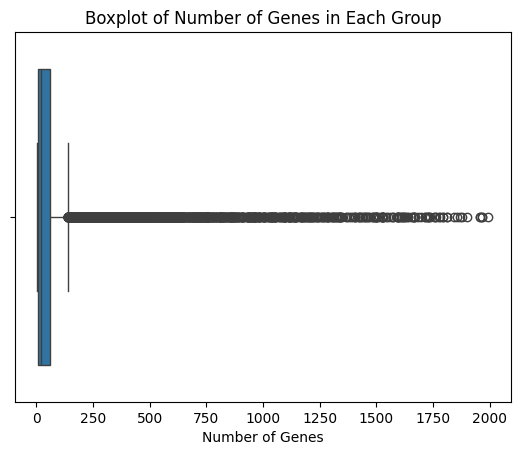

In [13]:
# Data Visualization

# Boxplot
sns.boxplot(x='GeneCount', data=gene_counts)
plt.title('Boxplot of Number of Genes in Each Group')
plt.xlabel('Number of Genes')
plt.show()

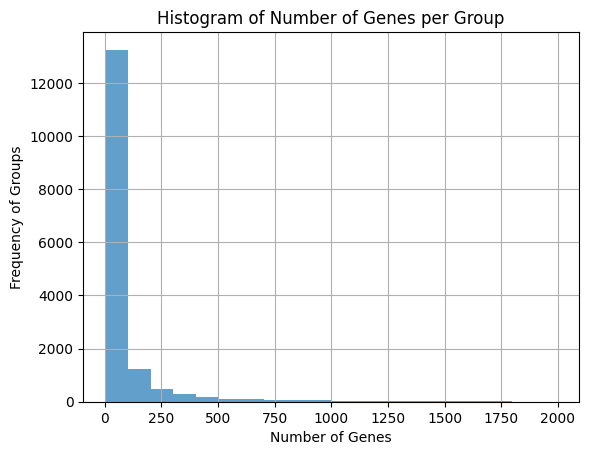

In [15]:
# Histogram

counts = vis_data.groupby('gene_set_id')['symbol'].count()
# Plot the histogram
counts.hist(alpha=0.7, bins=20)

# Add titles and labels
plt.title('Histogram of Number of Genes per Group')
plt.xlabel('Number of Genes')
plt.ylabel('Frequency of Groups')

# Show the plot
plt.show()

### Next word prediction

In [11]:
sentencelis = []
inputlis,outputlis = [],[]
uniq_gene = []
random.seed(42)
random.shuffle(overlap_index)
split_index = int(0.8 * len(overlap_index))

train_index = overlap_index[:split_index]
test_index = overlap_index[split_index:]

for index in train_index:
    uniq_gene.append(genelis_dic[index])

    sentence = '### Instruction: Provide some functional summary keywords of the relationship among the human genes. Make it coherent and concise. ### Input: The genes and corresponding descriptions are: ' + '; '.join(genelis_dic[index]) + '. ### Response: ' + geneset_dic[index]
    sentencelis.append(sentence)

for index in test_index:
    uniq_gene.append(genelis_dic[index])

    input = '### Instruction: Provide some functional summary keywords of the relationship among the human genes. Make it coherent and concise. ### Input: The genes and corresponding descriptions are: ' + '; '.join(genelis_dic[index]) + '. ### Response: '
    output = geneset_dic[index]
    inputlis.append(input)
    outputlis.append(output)

df_train = pd.DataFrame(sentencelis,columns=['sentence'])
df_test = pd.DataFrame(
        {'input': inputlis,
        'output': outputlis},
        columns = ['input', 'output'])

uniq_gene = set([i for sublist in uniq_gene for i in sublist])
df_train.to_json('/data/wchen19/geneset_summarization/train_test_data/subset_train_C5.json', orient='records', lines=True)
df_test.to_json('/data/wchen19/geneset_summarization/train_test_data/NCBI_long_prompt2_test_C5.json', orient='records',lines=True)

### Chat Template

In [5]:
## Latest version-Hold out/reactome external evaluation
import random
#holdout = pd.read_table('gpt_training_bio-main/llama2_ft/trl/train_test_data/hs/cross_val/hold-out-test.txt', header=None)

inputlis,outputlis = [],[]

#for index in holdout[0].values:
for index in geneset['gene_set_id'].values:
    input  = [
    {'role': 'system', 'content': 'You are a senior biologist.'},
    {
        'role': 'user', 'content': 'Propose a brief description for the most prominent biological function performed by the given set of genes. Be concise, do not use unnecessary words. Be specific, avoid overly general statements such as \"the genes are involved in various cellular processes\". Be factual, do not editorialize. The genes and corresponding descriptions are: ' + '; '.join(genelis_dic[index])
    }
    ]
    output = geneset_dic[index]
    inputlis.append(input)
    outputlis.append(output)

df_test = pd.DataFrame(
        {'input': inputlis,
        'output': outputlis},
        columns = ['input', 'output'])

df_test.to_json('gpt_training_bio-main/llama2_ft/trl/train_test_data/mm/mm_reactome_eval.json', orient='records',lines=True)

### Augmentation

In [6]:
aug_lis = []
random.seed(42)
random.shuffle(overlap_index)
split_index = int(0.8 * len(overlap_index))

train_index = overlap_index[:split_index]
test_index = overlap_index[split_index:]

for i in range (3):
    sentencelis = []
    for value in genelis_dic.values():
        random.shuffle(value)
    for index in train_index:
        sentence = 'Here is a gene set: ' + ', '.join(genelis_dic[index]) + '. Please provide a summary of the gene set: ' + geneset_dic[index]
        sentencelis.append(sentence)

    df_train = pd.DataFrame(sentencelis,columns=['sentence'])
    aug_lis.append(df_train)

aug = pd.concat(aug_lis)

aug.to_json('/data/wchen19/geneset_summarization/train_test_data/ttttrain_C5_aug.json', orient='records', lines=True)


### Seq2seq

In [23]:
# Shuffle genes
#random.seed(40)
shuffle_lis = []
for i in range (3):
    inputlis,outputlis = [],[]
    
    for value in genelis_dic.values():
        random.shuffle(value)

    for index in overlap_index:
        input = 'Here is a gene set: ' + ', '.join(genelis_dic[index]) + '. Please provide a summary of the gene set.'
        output = geneset_dic[index]
        inputlis.append(input)
        outputlis.append(output)

    QA = pd.DataFrame(
        {'input': inputlis,
        'output': outputlis},
        columns = ['input', 'output'])

    QA_train = QA.sample(frac = 0.8, random_state = 100)
    QA_test = QA.drop(labels=QA_train.index)
    shuffle_lis.append(QA_train)

shuffle = pd.concat(shuffle_lis)


In [39]:
def check_token(text):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf") ### remember to replace the path of the model
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=False))
    return len(tokens), tokens

token_num, token = check_token(', '.join(uniq_gene))
print(token_num)
average_token_per_gene = token_num/len(uniq_gene)
average_length_per_token = sum(([len(i) for i in token])) / len(([len(i) for i in token]))

101835


In [41]:
average_token_per_gene, average_length_per_token

(5.228474611079735, 1.4372268866303335)

In [17]:
a, b = check_token(inputlis[0])
a,b

/home/wchen19/miniconda3/envs/cu118/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(168,
 ['▁Here',
  '▁is',
  '▁a',
  '▁gene',
  '▁list',
  ':',
  '▁A',
  'K',
  'T',
  '3',
  ',',
  '▁P',
  'PAR',
  'GC',
  '1',
  'A',
  ',',
  '▁P',
  'OL',
  'G',
  '2',
  ',',
  '▁P',
  'AR',
  'P',
  '1',
  ',',
  '▁DNA',
  '2',
  ',',
  '▁T',
  'Y',
  'MP',
  ',',
  '▁F',
  'LC',
  'N',
  ',',
  '▁P',
  'RI',
  'MP',
  'OL',
  ',',
  '▁END',
  'O',
  'G',
  ',',
  '▁S',
  'TO',
  'X',
  '1',
  ',',
  '▁S',
  'LC',
  '2',
  '5',
  'A',
  '4',
  ',',
  '▁L',
  'IG',
  '3',
  ',',
  '▁ME',
  'F',
  '2',
  'A',
  ',',
  '▁MP',
  'V',
  '1',
  '7',
  ',',
  '▁OP',
  'A',
  '1',
  ',',
  '▁R',
  'R',
  'M',
  '2',
  'B',
  ',',
  '▁P',
  'OL',
  'G',
  ',',
  '▁S',
  'LC',
  '2',
  '5',
  'A',
  '3',
  '6',
  ',',
  '▁T',
  'WN',
  'K',
  ',',
  '▁R',
  'R',
  'M',
  '1',
  ',',
  '▁M',
  'ET',
  'TL',
  '4',
  ',',
  '▁S',
  'SB',
  'P',
  '1',
  ',',
  '▁T',
  'OP',
  '3',
  'A',
  ',',
  '▁T',
  'P',
  '5',
  '3',
  ',',
  '▁TE',
  'FM',
  ',',
  '▁P',
  'IF',
  '1',
  ',',
  '▁S'

## Dataset: TweetSumm

In [1]:
from datasets import Dataset, load_dataset
import json
import re

/home/wchen19/miniconda3/envs/cu118/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("Salesforce/dialogstudio", "TweetSumm")
dataset

/home/wchen19/miniconda3/envs/cu118/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for Salesforce/dialogstudio contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Salesforce/dialogstudio
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
    test: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
})

In [3]:
DEFAULT_SYSTEM_PROMPT = """
Below is a conversation between a human and an AI agent. Write a summary of the conversation.
""".strip()


def generate_training_prompt(
    conversation: str, summary: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT
) -> str:
    return f"""### Instruction: {system_prompt}

### Input:
{conversation.strip()}

### Response:
{summary}
""".strip()

In [4]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[^\s]+", "", text)
    text = re.sub(r"\s+", " ", text)
    return re.sub(r"\^[^ ]+", "", text)


def create_conversation_text(data_point):
    text = ""
    for item in data_point["log"]:
        user = clean_text(item["user utterance"])
        text += f"user: {user.strip()}\n"

        agent = clean_text(item["system response"])
        text += f"agent: {agent.strip()}\n"

    return text

In [5]:
def generate_text(data_point):
    summaries = json.loads(data_point["original dialog info"])["summaries"][
        "abstractive_summaries"
    ]
    summary = summaries[0]
    summary = " ".join(summary)

    conversation_text = create_conversation_text(data_point)
    return {
        "conversation": conversation_text,
        "summary": summary,
        "text": generate_training_prompt(conversation_text, summary),
    }

In [15]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_text)
        .remove_columns(
            [
                "original dialog id",
                "new dialog id",
                "dialog index",
                "original dialog info",
                "log",
                "prompt",
            ]
        )
    )

In [16]:
dataset["train"] = process_dataset(dataset["train"])
dataset["validation"] = process_dataset(dataset["validation"])

### Training loss

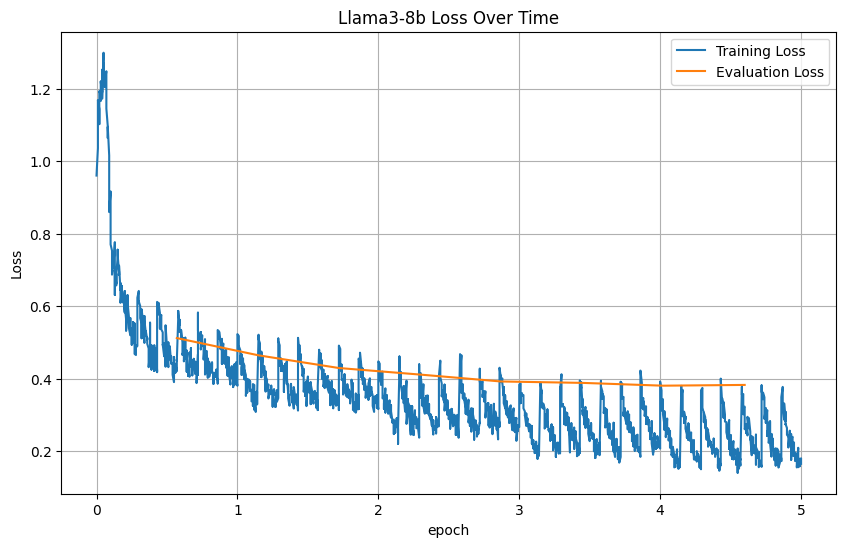

In [13]:
import json
import matplotlib.pyplot as plt

# Load the trainer_state JSON data from file
with open('/data/wchen19/geneset_summarization/llama3_8b/hs/new_human_0shot/checkpoint-1740/trainer_state.json', 'r') as file:
    data = json.load(file)

# Extract epochs and loss values
train_steps = [entry['epoch'] for entry in data['log_history'] if 'loss' in entry]
train_losses = [entry['loss'] for entry in data['log_history'] if 'loss' in entry]
eval_steps = [entry['epoch'] for entry in data['log_history'] if 'eval_loss' in entry]
eval_losses = [entry['eval_loss'] for entry in data['log_history'] if 'eval_loss' in entry]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Evaluation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Llama3-8b Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import pandas as pd
metrics = pd.read_csv('/data/wchen19/geneset_summarization/mistral_8_7b/NCBI_long_chattem_prompt3_eval_table_wo_ft.csv')

In [4]:
print(f"Number of predictions: {metrics.shape[0]}")
print(f"Average rouge_1 F1 score: {metrics['rouge_1_f'].mean()}")
print(f"Average rouge_2 F1 score: {metrics['rouge_2_f'].mean()}")
print(f"Average rouge_l F1 score: {metrics['rouge_l_f'].mean()}")
print(f"Average Bert F1 score: {metrics['bertscore'].mean()}")

Number of predictions: 2956
Average rouge_1 F1 score: 0.06085732833841761
Average rouge_2 F1 score: 0.0053720806176137045
Average rouge_l F1 score: 0.05367299961975508
Average Bert F1 score: 0.8276069208233541


### Result Statistics

In [3]:
import pandas as pd
#result = pd.read_csv('gpt_training_bio-main/llama2_ft/trl/train_test_data/rephrased_l2s_30_50_mm_gene_set_details.csv', index_col=0)
result = pd.read_csv('/data/wchen19/geneset_summarization/llama3_8b/hs/newrephrase_human_0shot_eval_ft_1k.csv')
result

,reference_summ,generated_summ,rouge_1_f,rouge_2_f,rouge_l_f,bertscore
0,"the formation and maturation of myoblasts, whi...",the formation and maturation of hair follicles...,0.357143,0.275862,0.357143,0.907601
1,the series of events involved in the formation...,the formation and maturation of the pharyngeal...,0.400000,0.272727,0.342857,0.896316
2,the chemical reactions and pathways by which t...,the chemical reactions and pathways by which t...,0.604651,0.510638,0.604651,0.935453
3,controlling the movement of polyamines across ...,the control of the enzyme ornithine decarboxyl...,0.315789,0.000000,0.210526,0.869657
4,the production of complex molecules that are n...,the series of chemical reactions and pathways ...,0.208333,0.000000,0.208333,0.858950
...,...,...,...,...,...,...
985,the critical phase in meiosis where chromosome...,the control of the transition from metaphase t...,0.285714,0.076923,0.122449,0.882555
986,the ongoing upkeep and repair of photoreceptor...,the movement of substances into a cell through...,0.210526,0.048780,0.210526,0.873258
987,the movement and insertion of proteins into ce...,the movement of newly made proteins from the c...,0.409091,0.042553,0.363636,0.896970
988,controlling the attachment of synaptic membran...,the inhibition of the formation and organizati...,0.540541,0.256410,0.486486,0.913042


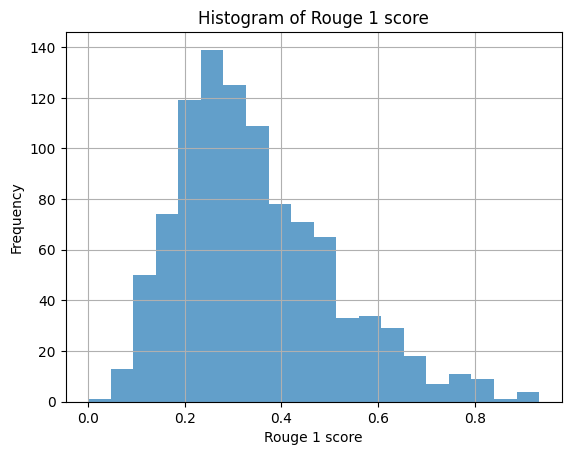

In [4]:
import matplotlib.pyplot as plt
# Histogram
result['rouge_1_f'].hist(alpha=0.7, bins=20)

# Add titles and labels
plt.title('Histogram of Rouge 1 score')
plt.xlabel('Rouge 1 score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [5]:
result[result['rouge_1_f'] > 0.5]

,reference_summ,generated_summ,rouge_1_f,rouge_2_f,rouge_l_f,bertscore
3,The process in which a relatively unspecialize...,Any process that activates or increases the fr...,0.666667,0.432432,0.666667,0.896361
8,Any process that results in a change in state ...,Any process that results in a change in state ...,0.805970,0.704545,0.805970,0.954271
14,"Any process that stops, prevents, or reduces t...","Any process that stops, prevents, or reduces t...",0.511628,0.384615,0.511628,0.910251
19,"Any process that stops, prevents, or reduces t...","Any process that stops, prevents, or reduces t...",0.521739,0.480000,0.521739,0.915700
21,Enables the transfer of a solute or solutes fr...,Enables the transfer of a solute or solutes fr...,0.750000,0.642857,0.708333,0.919586
...,...,...,...,...,...,...
1968,"Any process that modulates the frequency, rate...","Any process that modulates the frequency, rate...",0.510638,0.327869,0.510638,0.904658
1993,Catalysis of the reaction: S-adenosyl-L-methio...,Catalysis of the reaction: L-lysine + S-adenos...,0.558140,0.153846,0.418605,0.901650
1995,The series of molecular signals initiated by b...,The series of molecular signals initiated by b...,0.592593,0.490196,0.592593,0.919562
1997,Enables the transfer of a polyol from one side...,Enables the transfer of a solute or solutes fr...,0.571429,0.468085,0.571429,0.876778


In [2]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
import torch
def create_model_and_tokenizer():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

    model = AutoModelForCausalLM.from_pretrained(
        'mistralai/Mixtral-8x7B-Instruct-v0.1',
        use_safetensors=True,
        quantization_config=bnb_config,
        trust_remote_code=True,
        device_map="auto",
    )

    tokenizer = AutoTokenizer.from_pretrained('mistralai/Mixtral-8x7B-Instruct-v0.1')
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    return model, tokenizer

model, tokenizer = create_model_and_tokenizer()



/data/wchen19/miniconda3/envs/cu118/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


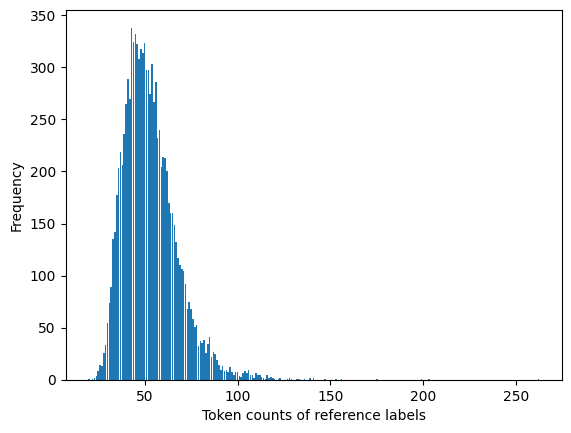

In [5]:
import matplotlib.pyplot as plt

counts = [len(tokenizer.convert_ids_to_tokens(tokenizer.encode(score, add_special_tokens=False))) for score in result[2].to_list()]
uniq_counts = list(set(counts))
plt.bar(uniq_counts, [counts.count(i) for i in uniq_counts])

# Add titles and labels
plt.xlabel('Token counts of reference labels')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [23]:
def word_count(text):
    word_tokens = re.findall(r'\b\w+\b', text)
    return len(word_tokens)

result['word_counts'] = [word_count(score) for score in result['rephrased'].to_list()]
result.sort_values(by='word_counts', ascending=False)

,gene_set_id,description_brief,description_full,source_species_code,exact_source,id,standard_name,collection_name,rephrased,word_counts
10414,10500,A general transcription initiation factor acti...,NaN,MM,GO:0016251,10500,GOMF_RNA_POLYMERASE_II_GENERAL_TRANSCRIPTION_I...,M5:GO:MF,"General transcription initiation factors, incl...",107
9742,9828,A general transcription initiation factor acti...,NaN,MM,GO:0001181,9828,GOMF_RNA_POLYMERASE_I_GENERAL_TRANSCRIPTION_IN...,M5:GO:MF,General transcription initiation factor activi...,102
8678,8764,A SAGA-type histone acetyltransferase complex ...,NaN,MM,GO:0000124,8764,GOCC_SAGA_COMPLEX,M5:GO:CC,The SAGA-type histone acetyltransferase comple...,98
8855,8941,"An intracellular organelle, about 200 A in dia...",NaN,MM,GO:0005840,8941,GOCC_RIBOSOME,M5:GO:CC,"The ribosome, an intracellular organelle appro...",96
8968,9054,An assembly of four or five subunits which for...,NaN,MM,GO:0017146,9054,GOCC_NMDA_SELECTIVE_GLUTAMATE_RECEPTOR_COMPLEX,M5:GO:CC,"The ionotropic glutamate receptor complex, com...",91
...,...,...,...,...,...,...,...,...,...,...
6065,6151,The process in which the anatomical structures...,NaN,MM,GO:0060425,6151,GOBP_LUNG_MORPHOGENESIS,M5:GO:BP,This process involves the generation and organ...,13
10021,10107,"Binding to a Notch (N) protein, a surface rece...",NaN,MM,GO:0005112,10107,GOMF_NOTCH_BINDING,M5:GO:MF,"A Notch (N) protein, functioning as a surface ...",12
7382,7468,The directed movement of neurotransmitter rece...,NaN,MM,GO:0099637,7468,GOBP_NEUROTRANSMITTER_RECEPTOR_TRANSPORT,M5:GO:BP,The process involves the controlled movement o...,12
11466,11552,Catalysis of the reaction:,NaN,MM,GO:0140824,11552,GOMF_THIOREDOXIN_DEPENDENT_PEROXIREDOXIN_ACTIVITY,M5:GO:MF,The content describes the process of catalyzin...,9


In [27]:
result.loc[10414:10414, 'rephrased'].values

array(['General transcription initiation factors, including TFIIB, TFIID, TFIIE, TFIIF, TFIIH, and TATA-binding protein, play a crucial role in selecting the transcription start site and initiating transcription for genes transcribed by RNA polymerase II. This enzyme is responsible for transcribing all messenger RNAs, most untranslated regulatory RNAs, the majority of snoRNAs, four of the five snRNAs (U1, U2, U4, and U5), and various small noncoding RNAs across most species. While RNA polymerase II typically handles these tasks, there is some variability with small RNAs between species, and in rare cases, like in Trypanosoma brucei, RNA polymerase I transcribes certain mRNAs besides its usual role in rRNA transcription.'],
      dtype=object)

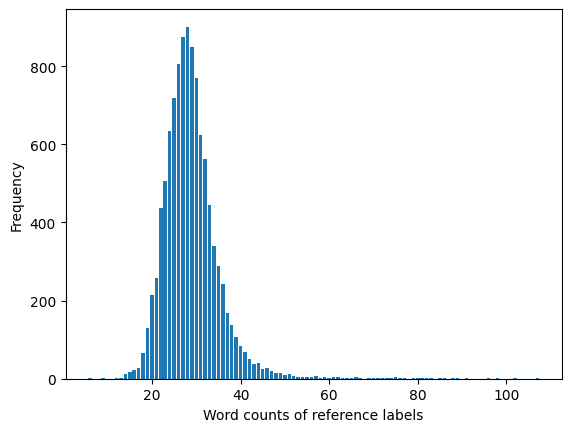

In [20]:
import re
import matplotlib.pyplot as plt
def word_count(text):
    word_tokens = re.findall(r'\b\w+\b', text)
    return len(word_tokens)

counts = [word_count(score) for score in result['rephrased'].to_list()]
uniq_counts = list(set(counts))
plt.bar(uniq_counts, [counts.count(i) for i in uniq_counts])

# Add titles and labels
plt.xlabel('Word counts of reference labels')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [4]:
import pandas as pd
GO_result = pd.read_csv('/data/wchen19/geneset_summarization/mistral_8_7b/mm/GPT_rephrased_withshortdesc_30_50_prompt4_GO_eval_table_ft.csv' , index_col=0)
GO_result

,reference_summ,generated_summ,rouge_1_f,rouge_2_f,rouge_l_f,bertscore
0,This process involves the enzymatic repair of ...,This process involves the enzymatic repair and...,0.508475,0.333333,0.508475,0.901831
1,This process involves the complex interplay of...,This process involves the transformation of ke...,0.438356,0.183908,0.301370,0.897534
2,This process involves the coordinated activity...,This process involves the coordinated action o...,0.285714,0.214286,0.285714,0.881014
3,This process involves the modulation of hormon...,This process involves the orchestration of hor...,0.656250,0.422535,0.625000,0.944042
4,This process involves the precise positioning ...,This process involves the orchestrated movemen...,0.328767,0.142857,0.328767,0.909667
...,...,...,...,...,...,...
2051,This process involves the breakdown of small m...,This process involves the enzymatic conversion...,0.411765,0.171429,0.323529,0.907217
2052,This process involves the modulation of cellul...,This process involves the intricate modulation...,0.376812,0.171429,0.318841,0.878006
2053,This process involves the enhancement of cellu...,This process involves the enhancement of DNA r...,0.461538,0.169492,0.423077,0.920286
2054,This process involves the enhancement of the i...,This process involves the enhancement of the i...,0.628571,0.500000,0.600000,0.935394


In [9]:
gene_num = []

import re
def word_count(text):
    word_tokens = re.findall(r'\b\w+\b', text)
    return len(word_tokens)

counts = [word_count(score) for index, score in GO_result['reference_summ'].items()]

for index, item in GO_result['reference_summ'].items():
    #GO_id = ontology_name2id[item]
    set_id = geneset_dic_GO2setid[item]
    num = len(genelis_dic[set_id])
    gene_num.append(num)
#GO_result.insert(0, 'gene_num', gene_num)
GO_result.insert(0, 'word_num', counts)

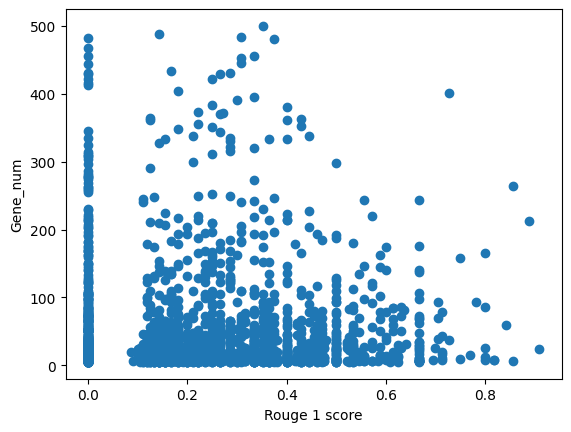

In [13]:
import matplotlib.pyplot as plt
plt.scatter(GO_result['rouge_1_f'], GO_result['gene_num'])
plt.xlabel('Rouge 1 score')
plt.ylabel('Gene_num')

# Show the plot
plt.show()

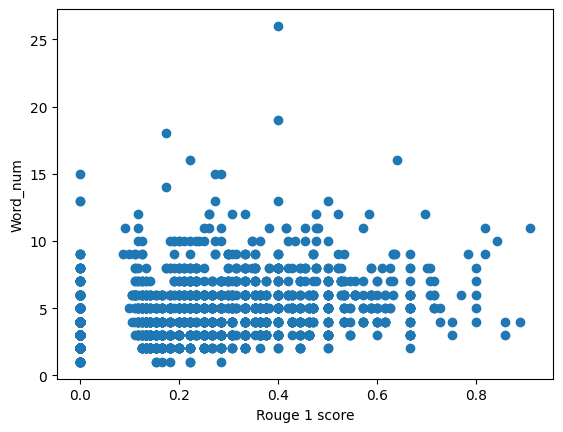

In [14]:
plt.scatter(GO_result['rouge_1_f'], GO_result['word_num'])
plt.xlabel('Rouge 1 score')
plt.ylabel('Word_num')

# Show the plot
plt.show()

## Orthologs

In [13]:
import pandas as pd
ortholog = pd.read_table('/data/wchen19/geneset_summarization/gene_orthologs')
ortholog

,#tax_id,GeneID,relationship,Other_tax_id,Other_GeneID
0,7955,30037,Ortholog,7782,129711934
1,7955,30037,Ortholog,7830,119955596
2,7955,30037,Ortholog,7936,118206824
3,7955,30037,Ortholog,7938,135265123
4,7955,30037,Ortholog,7959,127513223
...,...,...,...,...,...
9032196,10116,113911,Ortholog,143302,101618522
9032197,10116,113911,Ortholog,491861,114623965
9032198,10116,113911,Ortholog,1047088,119802524
9032199,10116,113911,Ortholog,1230840,103197150


In [14]:
hs2mm = ortholog[(ortholog['#tax_id'] == 9606) & (ortholog['Other_tax_id'] == 10090)]
mm2hs = ortholog[(ortholog['#tax_id'] == 10090) & (ortholog['Other_tax_id'] == 9606)]


,#tax_id,GeneID,relationship,Other_tax_id,Other_GeneID
1156097,9606,1,Ortholog,10090,117586
1156395,9606,9,Ortholog,10090,17960
1156619,9606,13,Ortholog,10090,67758
1156981,9606,14,Ortholog,10090,227290
1157530,9606,15,Ortholog,10090,11298
...,...,...,...,...,...
9029480,9606,122455339,Ortholog,10090,102634429
9029912,9606,122526779,Ortholog,10090,122526778
9030048,9606,122526780,Ortholog,10090,122526781
9030230,9606,124904660,Ortholog,10090,211135


In [103]:
hs2mm_dic = dict(zip(hs2mm['GeneID'], hs2mm['Other_GeneID']))
more = dict(zip(mm2hs['Other_GeneID'], mm2hs['GeneID']))
hs2mm_dic.update(more)
mm2hs_dic = dict(zip(hs2mm_dic.values(), hs2mm_dic.keys()))

In [108]:
len(hs2mm_dic)

16776

In [2]:
import pandas as pd
hsgeneset = pd.read_csv('human_gene_set_details.csv')
mmgeneset = pd.read_csv('mouse_gene_set_details.csv')
hsgenelis = pd.read_csv('gpt_training_bio-main/llama2_ft/trl/train_test_data/hs_gene_set_gene_symbol.csv')
mmgenelis = pd.read_csv('gpt_training_bio-main/llama2_ft/trl/train_test_data/mm_gene_set_gene_symbol.csv')
hs_gene_info = pd.read_table('gpt_training_bio-main/llama2_ft/trl/train_test_data/Homo_sapiens.gene_info')
mm_gene_info = pd.read_table('gpt_training_bio-main/llama2_ft/trl/train_test_data/Mus_musculus.gene_info')

In [3]:
hsgeneset['exact_source'].nunique()

array(['GO:0000002', 'GO:0000012', 'GO:0000018', ..., 'GO:1990935',
       'GO:1990948', 'GO:2001069'], dtype=object)

In [3]:
hsgene_symbol2id = dict(zip(hsgenelis['symbol'], hsgenelis['NCBI_id']))
hs_id2sybmol = dict(zip(hs_gene_info['GeneID'], hs_gene_info['Symbol']))
mmgene_symbol2id = dict(zip(mmgenelis['symbol'], mmgenelis['NCBI_id']))
mm_id2sybmol = dict(zip(mm_gene_info['GeneID'], mm_gene_info['Symbol']))

In [78]:
hs_index_l = []
for index, genes in hsgeneset['genelist'].items():
    i=0
    lis = []
    for gene in eval(genes):
        if hsgene_symbol2id[gene] in hs2mm_dic.keys():
            i+=1
    if i == len(eval(genes)):
        hs_index_l.append(index)

add_to_mouse = hsgeneset.loc[hs_index_l]
add_to_mouse['genelist'].apply(lambda x: str([mm_id2sybmol[hs2mm_dic[hsgene_symbol2id][i]]] for i in eval(x)))
new_mm_with_orth_hs = pd.concat([mmgeneset, add_to_mouse], join='outer')
new_mm_with_orth_hs.drop_duplicates(subset='exact_source', keep='first', inplace=True)
new_mm_with_orth_hs.reset_index(inplace=True)
new_mm_with_orth_hs.iloc[:, 2:].to_csv('augmented_mouse_gene_set_details.csv')

In [107]:
mm_index_l = []
for index, genes in mmgeneset['genelist'].items():
    i=0
    lis = []
    for gene in eval(genes):
        if mmgene_symbol2id[gene] in mm2hs_dic.keys():
            i+=1
    if i == len(eval(genes)):
        mm_index_l.append(index)

add_to_human = mmgeneset.loc[mm_index_l]
add_to_human['genelist'].apply(lambda x: str([hs_id2sybmol[mm2hs_dic[mmgene_symbol2id][i]]] for i in eval(x)))
new_hs_with_orth_mm = pd.concat([hsgeneset, add_to_human], join='outer')
new_hs_with_orth_mm.drop_duplicates(subset='exact_source', keep='first', inplace=True)
new_hs_with_orth_mm.reset_index(inplace=True)
new_hs_with_orth_mm.iloc[:, 2:].to_csv('augmented_human_gene_set_details.csv')

In [110]:
len(add_to_mouse)

4401

### eval_result_mapping

In [36]:
holdout_result_df = pd.read_csv('/data/wchen19/geneset_summarization/llama3_8b/hs/cross_val/hs_holdout_fold4.csv')
holdout = pd.merge(holdout_result_df, hsgeneset, how='left', left_on='reference_summ', right_on='rephrased')
holdout = holdout[['gene_set_id','GO_term', 'genelist','reference_summ', 'generated_summ', 'rouge_1_f', 'rouge_2_f', 'rouge_l_f', 'bertscore']]
holdout.to_csv('/data/wchen19/geneset_summarization/llama3_8b/hs/hold_result_details/hs_holdout_fold4_details.csv')

In [43]:
fold_num = 4
hs_rephr2id = dict(zip(hsgeneset['rephrased'], hsgeneset['gene_set_id']))
testset = pd.read_json('gpt_training_bio-main/llama2_ft/trl/train_test_data/hs/cross_val/fold'+str(fold_num)+'_test.json', orient='records', lines=True)
testset['gene_set_id'] = [hs_rephr2id[i] for i in testset['output'].values]
#testset['input'] = testset['input'].apply(lambda x: x[1]['content'])

In [41]:
fold_result_df = pd.read_csv('/data/wchen19/geneset_summarization/llama3_8b/hs/cross_val/hs_eval_fold'+str(fold_num)+'.csv')
fold = pd.merge(fold_result_df, hsgeneset, how='left', left_on='reference_summ', right_on='rephrased')
fold = pd.merge(fold, testset, how='left', on = 'gene_set_id')
fold = fold[['gene_set_id','GO_term', 'genelist','reference_summ', 'generated_summ', 'input', 'rouge_1_f', 'rouge_2_f', 'rouge_l_f', 'bertscore']]
fold.to_csv('/data/wchen19/geneset_summarization/llama3_8b/hs/five_fold_result_details/hs_eval_fold'+str(fold_num)+'_details.csv')

## Rephrased rationale

In [19]:
import pandas as pd
rationale = pd.read_csv('gpt_training_bio-main/llama2_ft/trl/train_test_data/GO_rephrased_rationale_hs.csv', header = None)
rationale.columns = ['gene_set_id', 'rephrased', 'rationale']
rationale

,gene_set_id,rephrased,rationale
0,12989,This process involves the coordination of key ...,Analysis:\n- AKT3 and PPARGC1A are involved in...
1,12991,This process involves the orchestration of mul...,- **XNDC1N and XRCC1** contribute to the recru...
2,12992,This process involves the intricate modulation...,Analysis:\n- **Enzyme Activation**: PARP1 and ...
3,12993,This process involves the coordination and con...,- RAD50 and MRE11 work in tandem within the MR...
4,12994,This process involves the coordination and int...,- **KIF4A and KIF4B**: These proteins belong t...
...,...,...,...
10087,23446,This process involves the targeted interaction...,- **DHX9** and **LARP6** highlight the diverse...
10088,23447,This process involves the selective attraction...,"- **TRIM28, EHMT2, and DNMT1** contribute to t..."
10089,23448,This process involves the interaction with com...,- **Complex Assembly and Regulation**: The int...
10090,23449,This process involves the inhibition of protei...,- The term highlights a specific biochemical a...


In [20]:
rationale = pd.merge(rationale, hsgeneset[['gene_set_id', 'GO_term', 'genelist']], how='left', on = 'gene_set_id')
rationale.to_csv('gpt_training_bio-main/llama2_ft/trl/train_test_data/GO_rephrased_rationale_mm.csv', index=None)

## Human evaluation

In [3]:
import pandas as pd
human_eval= pd.read_table('/data/wchen19/geneset_summarization/tmp_data_jinbo/back_trace_2k70b_woshot_all_bp_result_for_human_eval.tsv')
human_eval

,Genes,Real_GO,Real_Desc,Generated_Desc,Matched_GO,Matched_Desc,ROUGE-1_F1,ROUGE-2_F1,ROUGE-L_F1
0,Rps6-ps4 Pwp2 Fau Rpsa mt-Rnr1 Prkdc Rps14 Rps...,ribosomal small subunit assembly,This process involves the organized formation ...,This process involves the construction of a la...,cytosolic small ribosomal subunit assembly,This process involves the construction of the ...,0.888889,0.285714,0.666667
1,Ass1 Htt Otc Atp2b4 Ddah2 Aldh18a1 Ddah1 Cad,citrulline metabolic process,This process involves the chemical reactions a...,This process involves the chemical reactions a...,citrulline biosynthetic process,This process involves the series of chemical r...,0.666667,0.000000,0.666667
2,Adi1 Cth Mthfd1 Bhmt Cbs Ggt1 Mthfr Mtrr Mtr B...,sulfur amino acid biosynthetic process,This process involves the chemical reactions a...,This process involves the chemical reactions a...,hydroxylysine catabolic process,This process involves the breakdown of hydroxy...,0.250000,0.000000,0.250000
3,Mlh1 Terf1 Ube2b Xrcc5 Spo11 Mei1,leptotene,This process involves the initial stage of pro...,This process involves the division of homologo...,female meiosis chromosome separation,This process involves the division of chromoso...,0.000000,0.000000,0.000000
4,Psip1 Celf4 Srsf1 Celf1 Celf2 Srsf10 Luc7l2 Sl...,spliceosomal complex assembly,This process involves the gathering and organi...,This process involves the modification and rem...,"regulation of mRNA splicing, via spliceosome",This process involves the control of the modif...,0.222222,0.000000,0.222222
...,...,...,...,...,...,...,...,...,...
1484,Unc5b Agt Agtr2 App Atf3 Bcl10 Bid Bmpr1b Casp...,positive regulation of extrinsic apoptotic sig...,This process involves the enhancement of the e...,This process involves the activation or increa...,positive regulation of apoptotic process,This process involves enhancing or promoting t...,0.666667,0.400000,0.666667
1485,Unc5b Ctnna1 Dapk3 Inhba Jak3 Nf1 Ppp1ca Ret T...,positive regulation of extrinsic apoptotic sig...,This process involves the enhancement of the e...,This process involves the inhibition of the ad...,negative regulation of protein autophosphoryla...,This process involves the inhibition of a prot...,0.250000,0.142857,0.250000
1486,Casq1 Cd84 Slc8b1 Nfatc3 Spink1 Stc2 Stim1 Efh...,regulation of store-operated calcium entry,This process involves controlling the movement...,This process involves the enhancement of the e...,positive regulation of calcium ion transmembra...,This process involves the enhancement of the a...,0.428571,0.166667,0.428571
1487,Il9 Il9r Mmp9 Plaur Nle1 Park7 Caap1 Pih1d1,negative regulation of cysteine-type endopepti...,This process involves the reduction of the act...,This process involves the way cells react to t...,cellular response to interleukin-9,This process involves a cell's reaction to the...,0.000000,0.000000,0.000000


In [13]:
# Define the ranges for stratified sampling
ranges = [(i/10, (i+1)/10) for i in range(10)]

# Perform stratified sampling
sampled_data = pd.DataFrame()
for range_start, range_end in ranges:
    group = human_eval[(human_eval['ROUGE-1_F1'] >= range_start) & (human_eval['ROUGE-1_F1'] < range_end)]
    sampled_group = group.sample(n=10, random_state=42)  # Select 10 random rows from each group
    sampled_data = pd.concat([sampled_data, sampled_group])

sampled_data = sampled_data.sample(frac=1, random_state=100).reset_index(drop=True)
sampled_data.to_csv('/data/wchen19/geneset_summarization/human_eval.csv', index=False)

NameError: name 'human_eval' is not defined

In [34]:
import pandas as pd
eval_result = pd.read_csv('/data/wchen19/geneset_summarization/human_eval_graph_checked.csv')
eval_result['group'] = pd.cut(eval_result['ROUGE-1_F1'], bins=[i/5 for i in range(6)], labels=[f'{i/5:.1f}-{i/5+0.2:.1f}' for i in range(5)], right=False)
eval_result.head()

,Unnamed: 0,Genes,Real_GO,Real_GO_id,Real_Desc,Generated_Desc,Matched_GO,Matched_GO_id,Matched_Desc,ROUGE-1_F1,ROUGE-2_F1,ROUGE-L_F1,Graph_check,group
0,0,Timp4 Adam8 Adam9 Adra2a Apoe App Gpld1 Ifng I...,regulation of membrane protein ectodomain prot...,GO:0051043,This process involves the control of the cleav...,This process involves the inhibition of the ac...,negative regulation of metallopeptidase activity,GO:1905049,This process involves the inhibition of metall...,0.363636,0.222222,0.363636,0.0,0.2-0.4
1,1,Ccnb2 Cdc25a Cdc25b Cdc25c Pkmyt1 Ndc80,G2/MI transition of meiotic cell cycle,GO:0008315,This process involves the critical transition ...,This process involves the progression from one...,meiotic cell cycle phase transition,GO:0044771,This process involves the progression from one...,0.666667,0.400000,0.500000,0.5,0.6-0.8
2,2,Hsd3b7 Cyp27a1 Akr1c18 Hsd17b11 Apoe Cyp19a1 C...,steroid catabolic process,GO:0006706,This process involves the breakdown of steroid...,This process involves the chemical reactions a...,vitamin D3 metabolic process,GO:0070640,This process involves the chemical reactions a...,0.285714,0.000000,0.285714,0.0,0.2-0.4
3,3,Epha4 Cln5 Tgfb2 Rapgef3 Tns3 Poldip2,positive regulation of GTP binding,GO:1904426,This process involves enhancing the ability of...,This process involves controlling the activity...,regulation of Rho protein signal transduction,GO:0035023,This process involves controlling the activity...,0.363636,0.222222,0.363636,0.0,0.2-0.4
4,4,Il4i1 Ido1 Ido2 Acmsd Tdo2 Kynu Afmid Kmo,tryptophan catabolic process,GO:0006569,This process involves the breakdown of the ami...,This process involves the breakdown of the ami...,kynurenine metabolic process,GO:0070189,This process involves the breakdown and conver...,0.333333,0.000000,0.333333,0.5,0.2-0.4


/tmp/ipykernel_492842/3548582046.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_percentage = eval_result.groupby('group')['Graph_check'].value_counts(normalize=True).unstack().fillna(0)


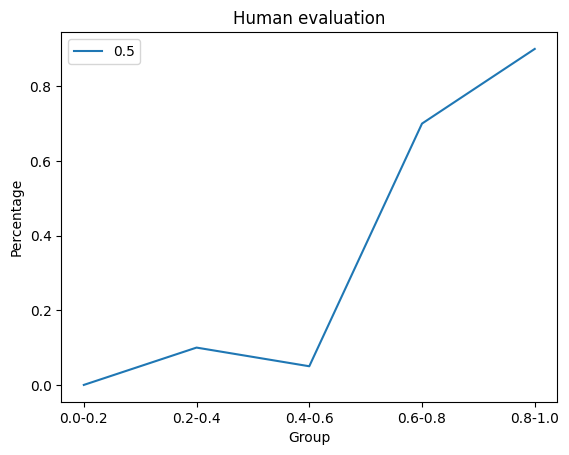

In [36]:
import matplotlib.pyplot as plt

# Calculate the percentage of 1.0 and 0.5+1.0 in A-B_consistent for each group
group_percentage = eval_result.groupby('group')['Graph_check'].value_counts(normalize=True).unstack().fillna(0)
#group_percentage['0.5+1.0'] = group_percentage[0.5] + group_percentage[1.0]

plt.plot(group_percentage.index, group_percentage[0.5], label='0.5')
#plt.plot(group_percentage.index, group_percentage['0.5+1.0'], label='0.5+1.0')

plt.xlabel('Group')
plt.ylabel('Percentage')
plt.title('Human evaluation')
plt.legend()

plt.show()


/tmp/ipykernel_2704790/3825999586.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = eval_result.groupby('group')['A-B_consistent'].value_counts().unstack().fillna(0)


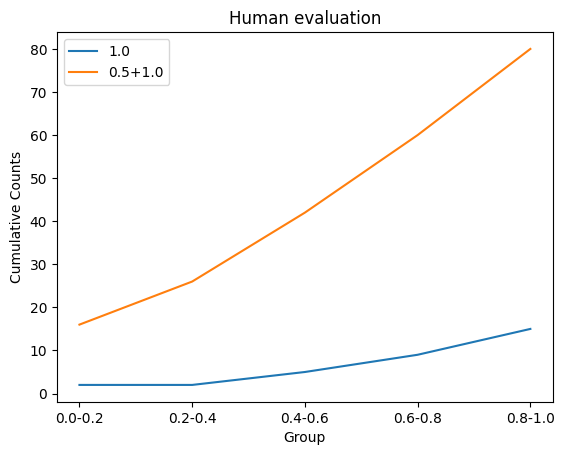

In [69]:
import matplotlib.pyplot as plt

# Calculate the percentage of 1.0 and 0.5+1.0 in A-B_consistent for each group
counts = eval_result.groupby('group')['A-B_consistent'].value_counts().unstack().fillna(0)
counts['0.5+1.0'] = counts[0.5] + counts[1.0]


plt.plot(counts.index, counts[1.0].cumsum(), label='1.0')
plt.plot(counts.index, counts['0.5+1.0'].cumsum(), label='0.5+1.0')

plt.xlabel('Group')
plt.ylabel('Cumulative Counts')
plt.title('Human evaluation')
plt.legend()

plt.show()

### Map to GO id

In [ ]:
import pandas as pd
import pronto
eval_result = pd.read_csv('/data/wchen19/geneset_summarization/human_eval.csv')

onto = pd.read_csv('/data/wchen19/geneset_summarization/dataset/go_terms_bp.csv')
ontology_name2id = {}
ontology_name2id = dict(zip(onto['Term_Description'], onto['GO']))

In [ ]:
eval_result.insert(2, 'Real_GO_id', [ontology_name2id[i] for i in eval_result['Real_GO']])
eval_result.insert(6, 'Matched_GO_id', [ontology_name2id[i] for i in eval_result['Matched_GO']])
eval_result.iloc[:, :-2].to_csv('/data/wchen19/geneset_summarization/human_eval_new.csv', index=False)

In [31]:
eval_result

,Genes,Real_GO,Real_GO_id,Real_Desc,Generated_Desc,Matched_GO,Matched_GO_id,Matched_Desc,ROUGE-1_F1,ROUGE-2_F1,ROUGE-L_F1,A-B_consistent,A-C_consistent
0,Timp4 Adam8 Adam9 Adra2a Apoe App Gpld1 Ifng I...,regulation of membrane protein ectodomain prot...,GO:0051043,This process involves the control of the cleav...,This process involves the inhibition of the ac...,negative regulation of metallopeptidase activity,GO:1905049,This process involves the inhibition of metall...,0.363636,0.222222,0.363636,0.0,1.0
1,Ccnb2 Cdc25a Cdc25b Cdc25c Pkmyt1 Ndc80,G2/MI transition of meiotic cell cycle,GO:0008315,This process involves the critical transition ...,This process involves the progression from one...,meiotic cell cycle phase transition,GO:0044771,This process involves the progression from one...,0.666667,0.400000,0.500000,0.5,1.0
2,Hsd3b7 Cyp27a1 Akr1c18 Hsd17b11 Apoe Cyp19a1 C...,steroid catabolic process,GO:0006706,This process involves the breakdown of steroid...,This process involves the chemical reactions a...,vitamin D3 metabolic process,GO:0070640,This process involves the chemical reactions a...,0.285714,0.000000,0.285714,0.5,1.0
3,Epha4 Cln5 Tgfb2 Rapgef3 Tns3 Poldip2,positive regulation of GTP binding,GO:1904426,This process involves enhancing the ability of...,This process involves controlling the activity...,regulation of Rho protein signal transduction,GO:0035023,This process involves controlling the activity...,0.363636,0.222222,0.363636,0.0,1.0
4,Il4i1 Ido1 Ido2 Acmsd Tdo2 Kynu Afmid Kmo,tryptophan catabolic process,GO:0006569,This process involves the breakdown of the ami...,This process involves the breakdown of the ami...,kynurenine metabolic process,GO:0070189,This process involves the breakdown and conver...,0.333333,0.000000,0.333333,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Impdh2-ps Entpd4b Efl1 Ndufb1 Ndufb11 Rhoq Uqc...,nucleoside triphosphate metabolic process,GO:0009141,This process involves the chemical reactions a...,This process involves the chemical reactions a...,nucleoside diphosphate metabolic process,GO:0009132,This process involves the chemical reactions a...,0.750000,0.333333,0.750000,0.5,1.0
96,Asic2 Asic1 Ctss Gip Gpr65 Kcne1 Asic3 Pck1 Lg...,response to acidic pH,GO:0010447,This process involves the reaction of a cell o...,This process involves the reaction of a cell o...,response to pH,GO:0009268,This process involves the way an organism or c...,0.857143,0.400000,0.857143,0.5,1.0
97,Atp6v1b1 Tmem199 Pip4p1 Aldob Atpaf1 Atpaf2 At...,proton-transporting two-sector ATPase complex ...,GO:0070071,This process involves the construction of a co...,This process involves the construction and org...,proton-transporting ATP synthase complex assembly,GO:0043461,This process involves the organized constructi...,0.615385,0.363636,0.615385,1.0,1.0
98,Snhg15 Kifc1 Chmp7 Prickle1 Cdc20 Tpr Abraxas2...,mitotic spindle assembly,GO:0090307,This process involves the formation of a struc...,This process involves the directed movement an...,protein localization to spindle pole body,GO:0071988,This process involves the precise movement and...,0.222222,0.000000,0.222222,0.0,1.0


In [1]:
# Caluculate scores
import pandas as pd
df = pd.read_csv('/data/wchen19/geneset_summarization/llama3_8b/mm/llama3_8b_mm_0shot_reactome_mouse_eval_table_w_ft_jinbo.csv')
df['rouge_1_f'].mean(), df['rouge_2_f'].mean(), df['rouge_l_f'].mean(), df['bertscore'].mean()

(0.3961903034261253,
 0.18000021521909432,
 0.3526516507420389,
 0.9051249060818771)